# Wiki Text Similarity Evaluation

This notebook evaluates OpenAI embeddings on `wiki_documents.jsonl` and `wiki_paragraphs.jsonl`.
The goal is to calculate the mean similarity score between original and spun texts and plot the distribution of these scores.

In [1]:
import json
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file.")

client = OpenAI(api_key=openai_api_key)
EMBED_MODEL = "text-embedding-3-small"
# OpenAI text-embedding-3-small context window is 8191 tokens.
# We'll truncate by characters as a rough proxy to avoid errors, approx 8000 chars.
MAX_CHARS = 8000 

def _prepare_text(text: str, max_chars: int = MAX_CHARS) -> str:
    if text is None:
        return ""
    text = text.strip()
    return text[:max_chars] if len(text) > max_chars else text

def batch_get_embeddings(texts, model=EMBED_MODEL, batch_size=50):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Prepare batch: truncate and ensure not empty
        prepared_batch = [_prepare_text(t) for t in batch]
        # Replace empty strings with a space to avoid API errors if any
        prepared_batch = [t if t else " " for t in prepared_batch]
        
        try:
            response = client.embeddings.create(model=model, input=prepared_batch)
            # Ensure we map embeddings back to order. response.data is a list.
            # The API guarantees order matches input list.
            batch_embeds = [item.embedding for item in response.data]
            embeddings.extend(batch_embeds)
        except Exception as e:
            print(f"Error fetching embeddings for batch starting at {i}: {e}")
            # Fallback: try one by one or just insert zeros/nans? 
            # For now, let's re-raise to notice issues.
            raise e
            
    return embeddings

def cosine_similarity(vec_a, vec_b):
    a = np.array(vec_a)
    b = np.array(vec_b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return float(np.dot(a, b) / (norm_a * norm_b))

def plot_similarity_distribution(similarities, title):
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.hist(similarities, bins=30, density=True, alpha=0.3, color='blue', label='Histogram')
    
    # Smooth KDE
    if len(similarities) > 1 and np.std(similarities) > 0:
        x_grid = np.linspace(min(similarities), max(similarities), 400)
        kde = gaussian_kde(similarities)
        plt.plot(x_grid, kde(x_grid), color='red', lw=2, label='Smooth KDE')
    
    plt.title(title)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


## 1. Evaluate `wiki_documents.jsonl`

Loading wiki_documents.jsonl...
Loaded 1990 documents.
Generating embeddings for documents (original)...
Generating embeddings for documents (spun)...
Mean similarity score for wiki_documents: 0.9332


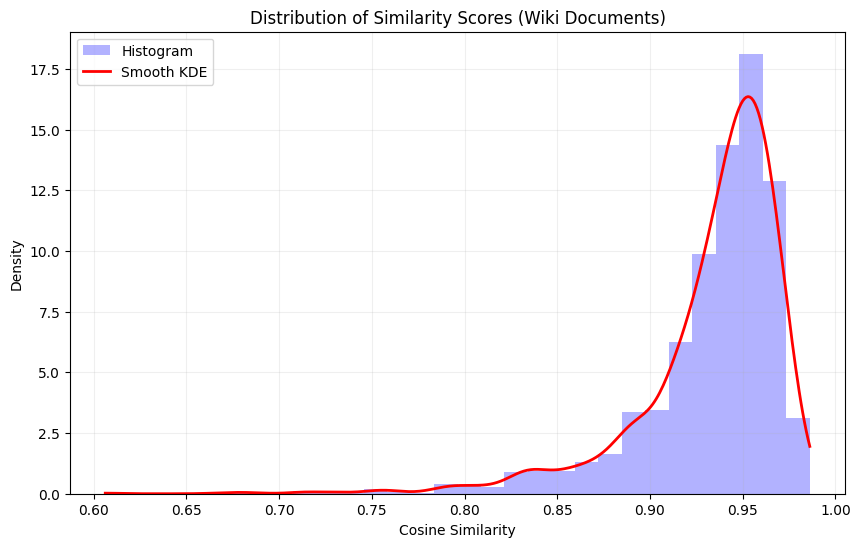

In [2]:
documents_path = "wiki_documents.jsonl"
print(f"Loading {documents_path}...")

doc_records = []
with open(documents_path, "r", encoding="utf-8") as fp:
    for line in fp:
        if line.strip():
            doc_records.append(json.loads(line))

print(f"Loaded {len(doc_records)} documents.")

# Extract text pairs
doc_orig_texts = [r.get("original_text", "") for r in doc_records]
doc_spun_texts = [r.get("spun_text", "") for r in doc_records]

print("Generating embeddings for documents (original)...")
doc_orig_embeds = batch_get_embeddings(doc_orig_texts)

print("Generating embeddings for documents (spun)...")
doc_spun_embeds = batch_get_embeddings(doc_spun_texts)

# Calculate similarities
doc_similarities = [
    cosine_similarity(e1, e2) for e1, e2 in zip(doc_orig_embeds, doc_spun_embeds)
]

mean_doc_sim = np.mean(doc_similarities)
print(f"Mean similarity score for wiki_documents: {mean_doc_sim:.4f}")

plot_similarity_distribution(doc_similarities, "Distribution of Similarity Scores (Wiki Documents)")

## 2. Evaluate `wiki_paragraphs.jsonl`

Loading wiki_paragraphs.jsonl...
Loaded 39105 paragraphs.
Generating embeddings for paragraphs (original)...
Generating embeddings for paragraphs (spun)...
Mean similarity score for wiki_paragraphs: 0.9161


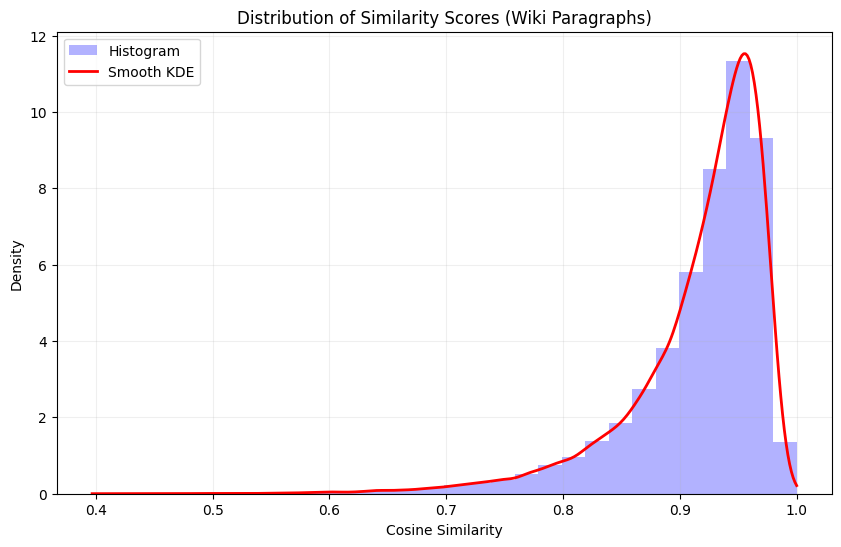

In [3]:
paragraphs_path = "wiki_paragraphs.jsonl"
print(f"Loading {paragraphs_path}...")

para_records = []
with open(paragraphs_path, "r", encoding="utf-8") as fp:
    for line in fp:
        if line.strip():
            para_records.append(json.loads(line))

print(f"Loaded {len(para_records)} paragraphs.")

# Extract text pairs
para_orig_texts = [r.get("original_text", "") for r in para_records]
para_spun_texts = [r.get("spun_text", "") for r in para_records]

print("Generating embeddings for paragraphs (original)...")
para_orig_embeds = batch_get_embeddings(para_orig_texts)

print("Generating embeddings for paragraphs (spun)...")
para_spun_embeds = batch_get_embeddings(para_spun_texts)

# Calculate similarities
para_similarities = [
    cosine_similarity(e1, e2) for e1, e2 in zip(para_orig_embeds, para_spun_embeds)
]

mean_para_sim = np.mean(para_similarities)
print(f"Mean similarity score for wiki_paragraphs: {mean_para_sim:.4f}")

plot_similarity_distribution(para_similarities, "Distribution of Similarity Scores (Wiki Paragraphs)")